In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install torchopenl3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 5.9 MB/s 
     |████████████████████████████████| 43 kB 2.2 MB/s 
     |████████████████████████████████| 323 kB 65.8 MB/s 
  Created wheel for julius: filename=julius-0.2.6-py3-none-any.whl size=20965 sha256=996a94737079be308eadfafcfd04528cd614b19b691c6d58014e2da494cc5569
  Stored in directory: /root/.cache/pip/wheels/ad/6f/00/57039014814f8794b1f32aad93d1d387645d103afdda943caf
  Created wheel for resampy: filename=resampy-0.2.2-py3-none-any.whl size=320732 sha256=34aa4bff97ff4ec40a42862b1906ac56a3f11df68d73f0d0d8fb1d3cb2c4df34
  Stored in directory: /root/.cache/pip/wheels/a0/18/0a/8ad18a597d8333a142c9789338a96a6208f1198d290ece356c
Successfully built julius resampy
  Attempting uninstall: resampy
    Found existing installation: resampy 0.4.0
    Uninstalling resampy-0.4.0:
      Successfully uninstalled resampy-0.4.0


In [ ]:
import sys
PATH_TO_FOLDER = '/content/drive/MyDrive/timbre_transfer/'
sys.path.append(PATH_TO_FOLDER)

In [ ]:
import model_vc
from model_vc import Generator

# Imports

In [ ]:
import os
import pickle
import numpy as np
import librosa
import torch
import soundfile as sf
from math import ceil
import requests
import torchopenl3
import torch
import matplotlib.pyplot as plt
from torch.nn import Conv1d
#from model_vc import Generator


# Check GPU availability

In [ ]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
  print(torch.cuda.get_device_name(0))
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

True
Tesla T4


# Generate mel spectrograms of test data

In [ ]:
!python /content/drive/MyDrive/timbre_transfer/make_spect.py

/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "
(513, 80)
['inst1', 'inst2', 'inst3', 'inst4', 'inst5', 'inst6', 'inst7']
Found directory: /content/drive/MyDrive/timbre_transfer/urmp_test_data
(24037, 513)
(22335, 513)
(24037, 513)
(7489, 513)
(7489, 513)
(7489, 513)
(32251, 513)
(22335, 513)
(8947, 513)
(32658, 513)
(24037, 513)
(22335, 513)
(15973, 513)
(15973, 513)


# Set spectrogram directories

In [ ]:
origin = 'inst7'

origin_mel_dir = '/content/drive/MyDrive/timbre_transfer/spmel_test/' + origin

In [ ]:
_, _, origin_file_list = next(os.walk(origin_mel_dir))

origin_file_list = sorted(origin_file_list)

# Set audio directories 

In [ ]:
dirName = '/content/drive/MyDrive/timbre_transfer/urmp_test_data'
target = 'inst1'
org_path = os.path.join(dirName, origin)
trg_path = os.path.join(dirName, target)

In [ ]:
print(org_path)
print(trg_path)

/content/drive/MyDrive/timbre_transfer/urmp_test_data/inst7
/content/drive/MyDrive/timbre_transfer/urmp_test_data/inst1


# Calculate speaker embeddings

In [ ]:
num_uttrs = 2
_, _, org_fileList = next(os.walk(org_path))

idx_uttrs = np.random.choice(len(org_fileList), size=num_uttrs, replace=False)
org_embs = []
count = 0
org_utterances = []
for i in range(num_uttrs):
    audio, sr = sf.read(os.path.join(org_path, org_fileList[idx_uttrs[i]]))

    emb, ts = torchopenl3.get_audio_embedding(audio, sr, content_type="music", input_repr="mel128",
                                                  embedding_size=512)
    count += 1
    in_chan = len(ts[0])  # size of input channels for the conv layer
    conv = Conv1d(in_chan, 1, 2, stride=2).cuda()  # initialise convolution layer
    emb = conv(emb)  # apply dimensionality reduction to original embeddings
    emb = torch.squeeze(emb, 1)  # remove 1 dimension
    org_embs.append(emb.detach().squeeze().cpu().numpy())

org_utterances.append(np.mean(org_embs, axis=0))


_, _, trg_fileList = next(os.walk(trg_path))

idx_uttrs = np.random.choice(len(trg_fileList), size=num_uttrs, replace=False)
trg_embs = []
trg_utterances = []
for i in range(num_uttrs):
    audio, sr = sf.read(os.path.join(trg_path, trg_fileList[idx_uttrs[i]]))

    emb, ts = torchopenl3.get_audio_embedding(audio, sr, content_type="music", input_repr="mel128",
                                                  embedding_size=512)
    in_chan = len(ts[0])  # size of input channels for the conv layer
    conv = Conv1d(in_chan, 1, 2, stride=2).cuda()  # initialise convolution layer
    emb = conv(emb)  # apply dimensionality reduction to original embeddings
    emb = torch.squeeze(emb, 1)  # remove 1 dimension
    trg_embs.append(emb.detach().squeeze().cpu().numpy())

trg_utterances.append(np.mean(trg_embs, axis=0))

In [ ]:
print(len(org_utterances[0]))
print(len(trg_utterances[0]))

256
256


# Load generator

In [ ]:
G = Generator(16,256,512,16).eval().to(device)
g_checkpoint = torch.load('/content/drive/MyDrive/timbre_transfer/new_trained_autovc.ckpt',map_location='cuda:0')
G.load_state_dict(g_checkpoint['model_state_dict'])

<All keys matched successfully>

# Add padding if required

In [ ]:
def pad_seq(x, base=32):
    len_out = int(base * ceil(float(x.shape[0])/base))
    len_pad = len_out - x.shape[0]
    assert len_pad >= 0
    return np.pad(x, ((0,len_pad),(0,0)), 'constant'), len_pad

# Prepare model inputs

In [ ]:
select = 0
print("Selected {}".format(origin_file_list[select]))
x_org = np.load(os.path.join(origin_mel_dir, origin_file_list[select]))  # load spectrogram

# Zero pad the sequence if it is too short
x_org, len_pad = pad_seq(x_org)

uttr_org = torch.from_numpy(x_org[np.newaxis, :, :]).to(device)
org_speaker = torch.from_numpy(org_utterances[0][np.newaxis, :]).to(device)
trg_speaker = torch.from_numpy(trg_utterances[0][np.newaxis, :]).to(device)

Selected AuSep_1_vn_26_King.npy


# Execute timbre transfer

In [ ]:
import librosa.display

In [ ]:
with torch.no_grad():
  _, result_mel, _ = G(uttr_org, org_speaker, trg_speaker)


# Reconstructing the source audio

In [ ]:
with torch.no_grad():
  _, result_mel, _ = G(uttr_org, org_speaker, org_speaker)

# Padding the produced spectrogram

In [ ]:
if len_pad == 0:
  uttr_trg = result_mel[0, 0, :, :].cpu().numpy()
else:
  uttr_trg = result_mel[0, 0, :-len_pad, :].cpu().numpy()
  

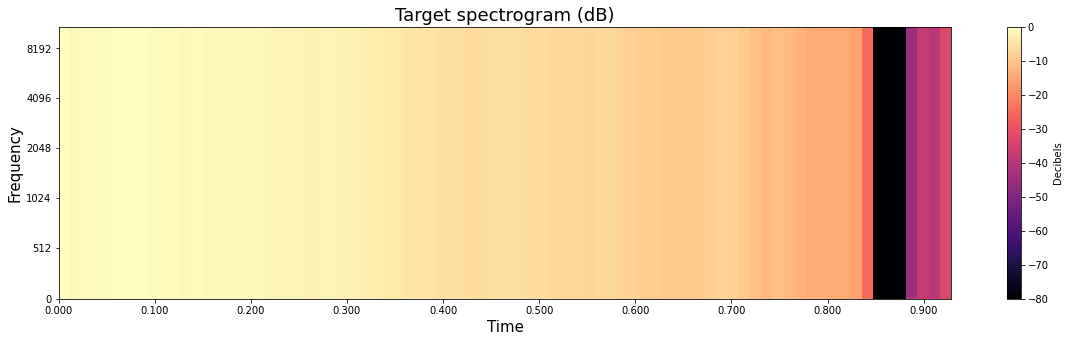

In [ ]:
mel = uttr_trg
target_spectrogram = librosa.power_to_db(mel, ref=np.max)
plt.figure(figsize=(20, 5))
hop_length = 256
librosa.display.specshow(target_spectrogram, sr = 22050, x_axis='time', y_axis='mel', hop_length=hop_length, cmap='magma')
plt.colorbar(label='Decibels')
plt.title('Target spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()


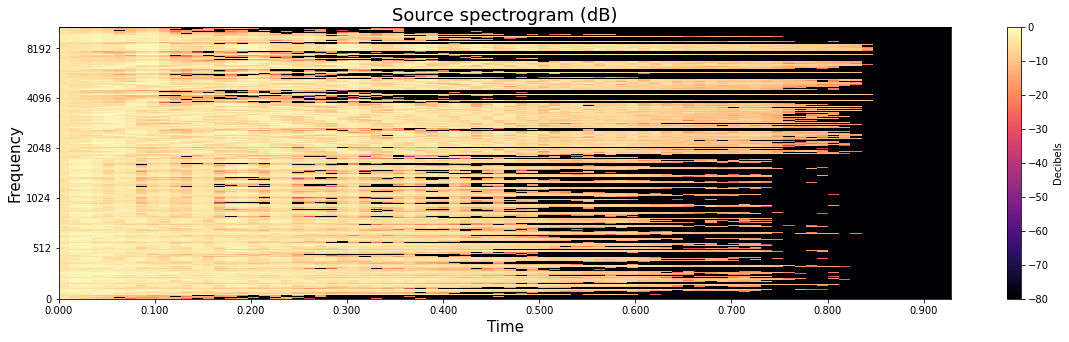

In [ ]:
mel = x_org
source_spectrogram = librosa.power_to_db(mel, ref=np.max)
plt.figure(figsize=(20, 5))
hop_length = 256
librosa.display.specshow(source_spectrogram, sr = 22050, x_axis='time', y_axis='mel', hop_length=hop_length, cmap='magma')
plt.colorbar(label='Decibels')
plt.title('Source spectrogram (dB)', fontdict=dict(size=18))
plt.xlabel('Time', fontdict=dict(size=15))
plt.ylabel('Frequency', fontdict=dict(size=15))
plt.show()

In [ ]:
import skimage
from skimage.metrics import structural_similarity as ssim

In [ ]:
padding = [0]*80
target_spectrogram = list(target_spectrogram)
idx = np.absolute(len(source_spectrogram) - len(target_spectrogram))
for i in range(0,idx):
    target_spectrogram.append(padding)
target_spectrogram = np.array(target_spectrogram)


print(len(target_spectrogram))
print(len(source_spectrogram))

16000
16000


In [ ]:
skimage.metrics.structural_similarity(source_spectrogram, target_spectrogram, data_range=1)

0.03673262839161302